请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

# **相关库导入**

In [ ]:
!pwd
!pip install scikit-image
!pip install pydicom
!pip install paddleseg

/home/aistudio
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/, https://pypi.tuna.tsinghua.edu.cn/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 4.1 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyWavelets: filename=PyWavelets-1.4.0-cp37-cp37m-linux_x86_64.whl size=5912056 sha256=84dd8f1e1cafaf803e535ffbb4ed85425031436775e6dd8c124e077785c68c2a
  Stored in directory: /home/aistudio/.cache/pip/wheels/ee/e9/77/648cd0740669dfca102c54f51d5bafacfd639faff2717c3c4e
Successfully built PyWavelets

[notice] A new release of pip available: 22.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Looking in indexes: h

In [ ]:
! git clone https://gitee.com/paddlepaddle/PaddleSeg.git
%cd ~/PaddleSeg/
! pip install paddleseg

fatal: destination path 'PaddleSeg' already exists and is not an empty directory.
/home/aistudio/PaddleSeg
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/, https://pypi.tuna.tsinghua.edu.cn/simple/

[notice] A new release of pip available: 22.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
! mkdir dataset
%cd dataset
!unzip -q -n /home/aistudio/data/data144729/RVSC.zip  -d /home/aistudio/PaddleSeg/dataset

In [ ]:
import pandas as pd
import os
from tqdm import tqdm
import logging
import numpy as np

from PIL import Image

import cv2
import pydicom
import matplotlib.pyplot as plt
import scipy.misc

# **数据集搭建**

In [ ]:
import os
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
import scipy.misc
import random

def mkdir(path):
 
	folder = os.path.exists(path)
 
	if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
		os.makedirs(path)            #makedirs 创建文件时如果路径不存在会创建这个路径
		print("---  OK  ---")
 
	else:
		print ("---  There is this folder!  ---")

def create_datalist(data_path,image_path,label_path):
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # 打乱数据
    k=0
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for i in data_names:
                patient_img=image_path+'/'+i
                label_img=label_path+'/'+i
                for j in os.listdir(patient_img):
                    # print(patient_img+'/'+j)
                    # print(label_img+'/'+j)
                    if k%9==0:
                        vf.write(patient_img+'/'+j + ' ' + label_img+'/'+j + '\n')
                    else:
                        tf.write(patient_img+'/'+j + ' ' + label_img+'/'+j + '\n')
                    k=k+1


def MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,model='train'):
    mkdir(label_path_out)
    mkdir(label_path_in)
    mkdir(data_path)
    for i in os.listdir(train_path):
        # print(i)
        patient=i[7:11]
        file=train_path+'/patient'+str(patient)+'/P'+str(patient)+'list.txt'
        print(file)
        names=[]
        with open(file) as f:
            line = f.readline()
            while line:
                # print(line.split('\\')[3][0:8])
                names.append(line.split('\\')[3][0:8])
                # line_float=[float(line.split()[0]),float(line.split()[1])]
                # array_in.append(line_float)
                line = f.readline()
                line = f.readline()
        for name in names:
            patient=name[1:3]
            idx=name[4:10]
            # print(patient,idx)
            
            path=train_path+'/patient'+str(patient)+'/P'+str(patient)+'dicom/P'+str(patient)+'-'+str(idx)+'.dcm'
            if(model=='train'):
                in_path=label_path+'/patient'+str(patient)+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-icontour-manual.txt'
                out_path=label_path+'/patient'+str(patient)+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-ocontour-manual.txt'
            else:
                in_path=label_path+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-icontour-manual.txt'
                out_path=label_path+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-ocontour-manual.txt'
            ds = pydicom.read_file(path)  #读取.dcm文件
            img = ds.pixel_array  # 提取图像信息
            
            # plt.axis('off')
            # plt.imshow(img)
            
            # plt.savefig(data_path+'/P'+str(patient)+'-'+str(idx)+'.png',bbox_inches='tight')
            cv2.imwrite(data_path+'/P'+str(patient)+'-'+str(idx)+'.png',img*255)
            # plt.close()
            array_in=[]
            array_out=[]
            with open(in_path) as f:
                line = f.readline()
                while line:
                        line_float=[float(line.split()[0]),float(line.split()[1])]
                        array_in.append(line_float)
                        line = f.readline()
                        
            with open(in_path) as f:
                line = f.readline()
                while line:
                    line_float=[float(line.split()[0]),float(line.split()[1])]
                    array_out.append(line_float)
                    line = f.readline()
            array_in=np.array(array_in)
            array_out=np.array(array_out)
            # print(type(array_in))
            imgName=data_path+'/P'+str(patient)+'-'+str(idx)+'.png'
            # 展示原图
            img_mask = cv2.imread(imgName)
            # plt.imshow(img_mask)
            # plt.axis('off')
            # 创建掩膜
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            
            polygon_in = np.array(array_in, np.int32) # 坐标为顺时针方向
            cv2.fillConvexPoly(mask, polygon_in, (255, 255, 255))
            # # 展示掩膜图片
            # plt.imshow(mask)
            cv2.imwrite(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png',mask)
            img=cv2.imread(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png')
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            difference = (img_gray.max() - img_gray.min()) // 2
            _, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
            cv2.imwrite(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png',img_binary)            
            # plt.savefig(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png',bbox_inches='tight')
            # plt.close()
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            polygon_out = np.array(array_out, np.int32) # 坐标为顺时针方向
            cv2.fillConvexPoly(mask, polygon_in, (255, 255, 255))

            # plt.axis('off')
            # plt.imshow(mask)
            # plt.savefig(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png',bbox_inches='tight')
            cv2.imwrite(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png',mask)
            img=cv2.imread(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png')
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            difference = (img_gray.max() - img_gray.min()) // 2
            _, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
            cv2.imwrite(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png',img_binary)
            # plt.close()

In [ ]:
train_path='/home/aistudio/PaddleSeg/dataset/RVSC/TrainingSet'
label_path='/home/aistudio/PaddleSeg/dataset/RVSC/TrainingSet'
data_path='/home/aistudio/PaddleSeg/dataset/train_img'
label_path_in='/home/aistudio/PaddleSeg/dataset/train_label_img_in'
label_path_out='/home/aistudio/PaddleSeg/dataset/train_label_img_out'
MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,'train')
train_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test1Set'
label_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test1SetContours/'
data_path='/home/aistudio/PaddleSeg/dataset/test1_img'
label_path_in='/home/aistudio/PaddleSeg/dataset/test1_label_img_in'
label_path_out='/home/aistudio/PaddleSeg/dataset/test1_label_img_out'
MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,'val')

train_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test2Set'
label_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test2SetContours/'
data_path='/home/aistudio/PaddleSeg/dataset/test2_img'
label_path_in='/home/aistudio/PaddleSeg/dataset/test2_label_img_in'
label_path_out='/home/aistudio/PaddleSeg/dataset/test2_label_img_out'
MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,'val')

In [ ]:
%cd /home/aistudio/PaddleSeg/dataset/
import random
!pwd
data_path=''
image_path='train_img'
label_path='train_label_img_in'
# create_datalist(data_path,image_path,label_path)
data_names = os.listdir(image_path)
random.shuffle(data_names)  # 打乱数据
k=0
with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
    with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
        for i in data_names:
            # print(i)
            patient_img=image_path+'/'+i
            label_img=label_path+'/'+i
            
            if k%9==0:
                vf.write(patient_img+ ' ' + label_img+ '\n')
            else:
                tf.write(patient_img + ' ' + label_img + '\n')
            k=k+1
data_path=''
image_path='test1_img'
label_path='test1_label_img_in'
data_names = os.listdir(image_path)
random.shuffle(data_names)  # 打乱数据
with open(os.path.join(data_path, 'test1_list.txt'), 'w') as tf:
    for i in data_names:
        patient_img=image_path+'/'+i
        label_img=label_path+'/'+i
        tf.write(patient_img +'\n')

data_path=''
image_path='test2_img'
label_path='test2_label_img_in'
data_names = os.listdir(image_path)
random.shuffle(data_names)  # 打乱数据
with open(os.path.join(data_path, 'test2_list.txt'), 'w') as tf:
    for i in data_names:
        patient_img=image_path+'/'+i
        label_img=label_path+'/'+i
        tf.write(patient_img+'\n')

/home/aistudio/PaddleSeg/dataset
/home/aistudio/PaddleSeg/dataset


In [ ]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

from paddleseg.cvlibs import manager


@manager.LOSSES.add_component
class BCELoss(nn.Layer):

    def __init__(self,
                 weight=None,
                 pos_weight=None,
                 ignore_index=255,
                 edge_label=False):
        super().__init__()
        self.weight = weight
        self.pos_weight = pos_weight
        self.ignore_index = ignore_index
        self.edge_label = edge_label
        self.EPS = 1e-10

        if self.weight is not None:
            if isinstance(self.weight, str):
                if self.weight != 'dynamic':
                    raise ValueError(
                        "if type of `weight` is str, it should equal to 'dynamic', but it is {}"
                        .format(self.weight))
            elif not isinstance(self.weight, paddle.Tensor):
                raise TypeError(
                    'The type of `weight` is wrong, it should be Tensor or str, but it is {}'
                    .format(type(self.weight)))

    def forward(self, logit, label):
        if len(label.shape) != len(logit.shape):
            label = paddle.unsqueeze(label, 1)
        mask = (label != self.ignore_index)
        mask = paddle.cast(mask, 'float32')
        # label.shape should equal to the logit.shape
        if label.shape[1] != logit.shape[1]:
            label = label.squeeze(1)
            label = F.one_hot(label, logit.shape[1])
            label = label.transpose((0, 3, 1, 2))
        if isinstance(self.weight, str):
            pos_index = (label == 1)
            neg_index = (label == 0)
            pos_num = paddle.sum(pos_index.astype('float32'))
            neg_num = paddle.sum(neg_index.astype('float32'))
            sum_num = pos_num + neg_num
            weight_pos = 2 * neg_num / (sum_num + self.EPS)
            weight_neg = 2 * pos_num / (sum_num + self.EPS)
            weight = weight_pos * label + weight_neg * (1 - label)
        else:
            weight = self.weight
        if isinstance(self.pos_weight, str):
            pos_index = (label == 1)
            neg_index = (label == 0)
            pos_num = paddle.sum(pos_index.astype('float32'))
            neg_num = paddle.sum(neg_index.astype('float32'))
            sum_num = pos_num + neg_num
            pos_weight = 2 * neg_num / (sum_num + self.EPS)
        else:
            pos_weight = self.pos_weight
        label = label.astype('float32')
        loss = paddle.nn.functional.binary_cross_entropy_with_logits(
            logit,
            label,
            weight=weight,
            reduction='none',
            pos_weight=pos_weight)
        loss = loss * mask
        loss = paddle.mean(loss) / (paddle.mean(mask) + self.EPS)
        label.stop_gradient = True
        mask.stop_gradient = True

        return loss

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddleseg/cvlibs/manager.py:114: UserWarning: BCELoss exists already! It is now updated to <class '__main__.BCELoss'> !!!
  format(component_name, component))


In [ ]:
%cd /home/aistudio/PaddleSeg/
# 参数调整
import paddle
from paddleseg.models import UNet, UNetPlusPlus

import paddleseg.transforms as T
from paddleseg.datasets import Dataset
# from paddleseg.models.losses import DiceLoss

# from paddleseg.models.losses import CrossEntropyLoss,FocalLoss,LovaszSoftmaxLoss
# 构建训练集
train_transforms = [
    T.RandomHorizontalFlip(),  # 水平翻转
    T.RandomVerticalFlip(),  # 垂直翻转
    T.RandomRotation(),  # 随机旋转
    T.RandomScaleAspect(),  # 随机缩放
    T.RandomDistort(),  # 随机扭曲
    T.Resize(target_size=(256, 256)),  # 这里为了加快速度，改为256x256
    T.Normalize()  # 归一化
]
train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='dataset',
    num_classes=2,
    mode='train',
    train_path='dataset/train_list.txt',
    separator=' ',
)
# 构建验证集
val_transforms = [
    T.Resize(target_size=(256, 256)),
    T.Normalize()
]
val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='dataset',
    num_classes=2,
    mode='val',
    val_path='dataset/val_list.txt',
    separator=' ',
)
# 优化器及损失
epochs = 5
batch_size = 16
# iters = epochs * 7278 // batch_size //2
iters=2000
base_lr = 2e-3
losses = {}
# losses['types'] = [LovaszSoftmaxLoss()]
# losses['coef'] = [1]
losses['types'] = [BCELoss()] 
losses['coef'] = [1]


/home/aistudio/PaddleSeg


In [ ]:
# 重写evaluate函数
# [Feature]:return值中增加了mdice
# 函数参数不需要进行改变，后续调用还是之前的样子

import os

import numpy as np
import time
import paddle
import paddle.nn.functional as F

from paddleseg.utils import metrics, TimeAverager, calculate_eta, logger, progbar
from paddleseg.core import infer

np.set_printoptions(suppress=True)

def evaluate(model,
             eval_dataset,
             aug_eval=False,
             scales=1.0,
             flip_horizontal=False,
             flip_vertical=False,
             is_slide=False,
             stride=None,
             crop_size=None,
             precision='fp32',
             amp_level='O1',
             num_workers=0,
             print_detail=True,
             auc_roc=False,
             use_multilabel=False):
    
    model.eval()
    nranks = paddle.distributed.ParallelEnv().nranks
    local_rank = paddle.distributed.ParallelEnv().local_rank
    if nranks > 1:
        # Initialize parallel environment if not done.
        if not paddle.distributed.parallel.parallel_helper._is_parallel_ctx_initialized(
        ):
            paddle.distributed.init_parallel_env()
    batch_sampler = paddle.io.DistributedBatchSampler(
        eval_dataset, batch_size=1, shuffle=False, drop_last=False)
    loader = paddle.io.DataLoader(
        eval_dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        return_list=True, )

    total_iters = len(loader)
    intersect_area_all = paddle.zeros([1], dtype='int64')
    pred_area_all = paddle.zeros([1], dtype='int64')
    label_area_all = paddle.zeros([1], dtype='int64')
    logits_all = None
    label_all = None

    if print_detail:
        logger.info("Start evaluating (total_samples: {}, total_iters: {})...".
                    format(len(eval_dataset), total_iters))
    #TODO(chenguowei): fix log print error with multi-gpus
    progbar_val = progbar.Progbar(
        target=total_iters, verbose=1 if nranks < 2 else 2)
    reader_cost_averager = TimeAverager()
    batch_cost_averager = TimeAverager()
    batch_start = time.time()
    with paddle.no_grad():
        for iter, data in enumerate(loader):
            reader_cost_averager.record(time.time() - batch_start)
            label = data['label'].astype('int64')

            if aug_eval:
                if precision == 'fp16':
                    with paddle.amp.auto_cast(
                            level=amp_level,
                            enable=True,
                            custom_white_list={
                                "elementwise_add", "batch_norm",
                                "sync_batch_norm"
                            },
                            custom_black_list={'bilinear_interp_v2'}):
                        pred, logits = infer.aug_inference(
                            model,
                            data['img'],
                            trans_info=data['trans_info'],
                            scales=scales,
                            flip_horizontal=flip_horizontal,
                            flip_vertical=flip_vertical,
                            is_slide=is_slide,
                            stride=stride,
                            crop_size=crop_size)
                            # use_multilabel=False)
                else:
                    pred, logits = infer.aug_inference(
                        model,
                        data['img'],
                        trans_info=data['trans_info'],
                        scales=scales,
                        flip_horizontal=flip_horizontal,
                        flip_vertical=flip_vertical,
                        is_slide=is_slide,
                        stride=stride,
                        crop_size=crop_size)
                        # use_multilabel=False)
            else:
                if precision == 'fp16':
                    with paddle.amp.auto_cast(
                            level=amp_level,
                            enable=True,
                            custom_white_list={
                                "elementwise_add", "batch_norm",
                                "sync_batch_norm"
                            },
                            custom_black_list={'bilinear_interp_v2'}):
                        pred, logits = infer.inference(
                            model,
                            data['img'],
                            trans_info=data['trans_info'],
                            is_slide=is_slide,
                            stride=stride,
                            crop_size=crop_size)
                            # use_multilabel=False)
                else:
                    pred, logits = infer.inference(
                        model,
                        data['img'],
                        trans_info=data['trans_info'],
                        is_slide=is_slide,
                        stride=stride,
                        crop_size=crop_size)
                        # use_multilabel=False)

            intersect_area, pred_area, label_area = metrics.calculate_area(
                pred,
                label,
                eval_dataset.num_classes,
                ignore_index=eval_dataset.ignore_index)
                # use_multilabel=False)

            # Gather from all ranks
            if nranks > 1:
                intersect_area_list = []
                pred_area_list = []
                label_area_list = []
                paddle.distributed.all_gather(intersect_area_list,
                                              intersect_area)
                paddle.distributed.all_gather(pred_area_list, pred_area)
                paddle.distributed.all_gather(label_area_list, label_area)

                # Some image has been evaluated and should be eliminated in last iter
                if (iter + 1) * nranks > len(eval_dataset):
                    valid = len(eval_dataset) - iter * nranks
                    intersect_area_list = intersect_area_list[:valid]
                    pred_area_list = pred_area_list[:valid]
                    label_area_list = label_area_list[:valid]

                for i in range(len(intersect_area_list)):
                    intersect_area_all = intersect_area_all + intersect_area_list[
                        i]
                    pred_area_all = pred_area_all + pred_area_list[i]
                    label_area_all = label_area_all + label_area_list[i]
            else:
                intersect_area_all = intersect_area_all + intersect_area
                pred_area_all = pred_area_all + pred_area
                label_area_all = label_area_all + label_area

                if auc_roc:
                    logits = F.softmax(logits, axis=1)
                    if logits_all is None:
                        logits_all = logits.numpy()
                        label_all = label.numpy()
                    else:
                        logits_all = np.concatenate(
                            [logits_all, logits.numpy()])  # (KN, C, H, W)
                        label_all = np.concatenate([label_all, label.numpy()])

            batch_cost_averager.record(
                time.time() - batch_start, num_samples=len(label))
            batch_cost = batch_cost_averager.get_average()
            reader_cost = reader_cost_averager.get_average()

            if local_rank == 0 and print_detail:
                progbar_val.update(iter + 1, [('batch_cost', batch_cost),
                                              ('reader cost', reader_cost)])
            reader_cost_averager.reset()
            batch_cost_averager.reset()
            batch_start = time.time()

    metrics_input = (intersect_area_all, pred_area_all, label_area_all)
    class_iou, miou = metrics.mean_iou(*metrics_input)
    acc, class_precision, class_recall = metrics.class_measurement(
        *metrics_input)
    kappa = metrics.kappa(*metrics_input)
    class_dice, mdice = metrics.dice(*metrics_input)

    if auc_roc:
        auc_roc = metrics.auc_roc(
            logits_all, label_all, num_classes=eval_dataset.num_classes)
        auc_infor = ' Auc_roc: {:.4f}'.format(auc_roc)

    if print_detail:
        infor = "[EVAL] #Images: {} mIoU: {:.4f} Acc: {:.4f} Kappa: {:.4f} Dice: {:.4f}".format(
            len(eval_dataset), miou, acc, kappa, mdice)
        infor = infor + auc_infor if auc_roc else infor
        logger.info(infor)
        logger.info("[EVAL] Class IoU: \n" + str(np.round(class_iou, 4)))
        logger.info("[EVAL] Class Precision: \n" + str(
            np.round(class_precision, 4)))
        logger.info("[EVAL] Class Recall: \n" + str(np.round(class_recall, 4)))
    return miou, acc, class_iou, class_precision, kappa , mdice

In [ ]:
# 重写train函数
import os
import time
from collections import deque
import shutil

import paddle
import paddle.nn.functional as F

from paddleseg.utils import (TimeAverager, calculate_eta, resume, logger,
                             worker_init_fn, train_profiler, op_flops_funs)
# 因为重写了evaluate函数，所以没有用paddleseg自身的
# from paddleseg.core.val import evaluate


def check_logits_losses(logits_list, losses):
    len_logits = len(logits_list)
    len_losses = len(losses['types'])
    if len_logits != len_losses:
        raise RuntimeError(
            'The length of logits_list should equal to the types of loss config: {} != {}.'
            .format(len_logits, len_losses))


def loss_computation(logits_list, labels, losses, edges=None):
    check_logits_losses(logits_list, losses)
    loss_list = []
    for i in range(len(logits_list)):
        logits = logits_list[i]
        loss_i = losses['types'][i]
        coef_i = losses['coef'][i]

        if loss_i.__class__.__name__ == 'MixedLoss':
            mixed_loss_list = loss_i(logits, labels)
            for mixed_loss in mixed_loss_list:
                loss_list.append(coef_i * mixed_loss)
        elif loss_i.__class__.__name__ in ("KLLoss", ):
            loss_list.append(coef_i *
                             loss_i(logits_list[0], logits_list[1].detach()))
        else:
            loss_list.append(coef_i * loss_i(logits, labels))
    return loss_list


# 新增了一个参数 filename 就是保存的npy文件位置 位置就是save_dir+filename，这个文件中保存的是loss的信息
# 还要增加一个参数dicepath，这个npy文件中保存的是dice的信息
def train(model,
          train_dataset,
          filename,
          dicepath,
          val_dataset=None,
          optimizer=None,
          save_dir='output',
          iters=10000,
          batch_size=2,
          resume_model=None,
          save_interval=1000,
          log_iters=10,
          num_workers=0,
          use_vdl=False,
          losses=None,
          keep_checkpoint_max=5,
          test_config=None,
          precision='fp32',
          amp_level='O1',
          profiler_options=None,
          to_static_training=False):
    filename=save_dir+'/'+filename
    print(filename)
    dicepath=save_dir+'/'+dicepath
    print(dicepath)
    model.train()
    nranks = paddle.distributed.ParallelEnv().nranks
    local_rank = paddle.distributed.ParallelEnv().local_rank

    start_iter = 0
    if resume_model is not None:
        start_iter = resume(model, optimizer, resume_model)

    if not os.path.isdir(save_dir):
        if os.path.exists(save_dir):
            os.remove(save_dir)
        os.makedirs(save_dir)

    # use amp
    if precision == 'fp16':
        logger.info('use AMP to train. AMP level = {}'.format(amp_level))
        scaler = paddle.amp.GradScaler(init_loss_scaling=1024)
        if amp_level == 'O2':
            model, optimizer = paddle.amp.decorate(
                models=model,
                optimizers=optimizer,
                level='O2',
                save_dtype='float32')

    if nranks > 1:
        paddle.distributed.fleet.init(is_collective=True)
        optimizer = paddle.distributed.fleet.distributed_optimizer(
            optimizer)  # The return is Fleet object
        ddp_model = paddle.distributed.fleet.distributed_model(model)

    batch_sampler = paddle.io.DistributedBatchSampler(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    loader = paddle.io.DataLoader(
        train_dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        return_list=True,
        worker_init_fn=worker_init_fn, )

    if use_vdl:
        from visualdl import LogWriter
        log_writer = LogWriter(save_dir)

    if to_static_training:
        model = paddle.jit.to_static(model)
        logger.info("Successfully to apply @to_static")

    avg_loss = 0.0
    avg_loss_list = []
    iters_per_epoch = len(batch_sampler)
    best_mean_iou = -1.0
    best_model_iter = -1
    reader_cost_averager = TimeAverager()
    batch_cost_averager = TimeAverager()
    save_models = deque()
    batch_start = time.time()
    
    # 为了画出dice图像
    # 定义一个用于记录Dice的列表
    dice_save_list = []
    

    iter = start_iter
    loss_save_list=[]
    while iter < iters:
        for data in loader:
            iter += 1
            if iter > iters:
                version = paddle.__version__
                if version == '2.1.2':
                    continue
                else:
                    break
            reader_cost_averager.record(time.time() - batch_start)
            images = data['img']
            labels = data['label'].astype('int64')
            # print(labels.shape)
            edges = None
            if len(data) == 3:
                edges = data[2].astype('int64')
            if hasattr(model, 'data_format') and model.data_format == 'NHWC':
                images = images.transpose((0, 2, 3, 1))

            
            logits_list = ddp_model(images) if nranks > 1 else model(images)
            loss_list = loss_computation(
                logits_list=logits_list,
                labels=labels,
                losses=losses,
                edges=edges)
            loss = sum(loss_list)
            # 这一步保存loss
            loss_save_list.append(loss)
            loss.backward()
            # if the optimizer is ReduceOnPlateau, the loss is the one which has been pass into step.
            if isinstance(optimizer, paddle.optimizer.lr.ReduceOnPlateau):
                optimizer.step(loss)
            else:
                optimizer.step()

            lr = optimizer.get_lr()

            # update lr
            if isinstance(optimizer, paddle.distributed.fleet.Fleet):
                lr_sche = optimizer.user_defined_optimizer._learning_rate
            else:
                lr_sche = optimizer._learning_rate
            if isinstance(lr_sche, paddle.optimizer.lr.LRScheduler):
                lr_sche.step()

            train_profiler.add_profiler_step(profiler_options)

            model.clear_gradients()
            avg_loss += loss.numpy()[0]
            
            if not avg_loss_list:
                avg_loss_list = [l.numpy() for l in loss_list]
            else:
                for i in range(len(loss_list)):
                    avg_loss_list[i] += loss_list[i].numpy()
            batch_cost_averager.record(
                time.time() - batch_start, num_samples=batch_size)

            if (iter) % log_iters == 0 and local_rank == 0:
                avg_loss /= log_iters
                avg_loss_list = [l[0] / log_iters for l in avg_loss_list]
                remain_iters = iters - iter
                avg_train_batch_cost = batch_cost_averager.get_average()
                avg_train_reader_cost = reader_cost_averager.get_average()
                eta = calculate_eta(remain_iters, avg_train_batch_cost)
                logger.info(
                    "[TRAIN] epoch: {}, iter: {}/{}, loss: {:.4f}, lr: {:.6f}, batch_cost: {:.4f}, reader_cost: {:.5f}, ips: {:.4f} samples/sec | ETA {}"
                    .format((iter - 1
                             ) // iters_per_epoch + 1, iter, iters, avg_loss,
                            lr, avg_train_batch_cost, avg_train_reader_cost,
                            batch_cost_averager.get_ips_average(), eta))
                if use_vdl:
                    log_writer.add_scalar('Train/loss', avg_loss, iter)
                    # Record all losses if there are more than 2 losses.
                    if len(avg_loss_list) > 1:
                        avg_loss_dict = {}
                        for i, value in enumerate(avg_loss_list):
                            avg_loss_dict['loss_' + str(i)] = value
                        for key, value in avg_loss_dict.items():
                            log_tag = 'Train/' + key
                            log_writer.add_scalar(log_tag, value, iter)

                    log_writer.add_scalar('Train/lr', lr, iter)
                    log_writer.add_scalar('Train/batch_cost',
                                          avg_train_batch_cost, iter)
                    log_writer.add_scalar('Train/reader_cost',
                                          avg_train_reader_cost, iter)
                avg_loss = 0.0
                avg_loss_list = []
                reader_cost_averager.reset()
                batch_cost_averager.reset()

            if (iter % save_interval == 0 or
                    iter == iters) and (val_dataset is not None):
                num_workers = 1 if num_workers > 0 else 0

                if test_config is None:
                    test_config = {}

                mean_iou, acc, _, _, _ , mdice = evaluate(
                    model,
                    val_dataset,
                    num_workers=num_workers,
                    precision=precision,
                    amp_level=amp_level,
                    **test_config,
                    use_multilabel=False)
                
                # 保存dice
                dice_save_list.append(mdice)

                model.train()

            if (iter % save_interval == 0 or iter == iters) and local_rank == 0:
                current_save_dir = os.path.join(save_dir,
                                                "iter_{}".format(iter))
                if not os.path.isdir(current_save_dir):
                    os.makedirs(current_save_dir)
                paddle.save(model.state_dict(),
                            os.path.join(current_save_dir, 'model.pdparams'))
                paddle.save(optimizer.state_dict(),
                            os.path.join(current_save_dir, 'model.pdopt'))
                save_models.append(current_save_dir)
                if len(save_models) > keep_checkpoint_max > 0:
                    model_to_remove = save_models.popleft()
                    shutil.rmtree(model_to_remove)

                if val_dataset is not None:
                    if mean_iou > best_mean_iou:
                        best_mean_iou = mean_iou
                        best_model_iter = iter
                        best_model_dir = os.path.join(save_dir, "best_model")
                        paddle.save(
                            model.state_dict(),
                            os.path.join(best_model_dir, 'model.pdparams'))
                    logger.info(
                        '[EVAL] The model with the best validation mIoU ({:.4f}) was saved at iter {}.'
                        .format(best_mean_iou, best_model_iter))

                    if use_vdl:
                        log_writer.add_scalar('Evaluate/mIoU', mean_iou, iter)
                        log_writer.add_scalar('Evaluate/Acc', acc, iter)
            batch_start = time.time()

    # Calculate flops.
    if local_rank == 0 and not (precision == 'fp16' and amp_level == 'O2'):
        _, c, h, w = images.shape
        _ = paddle.flops(
            model, [1, c, h, w],
            custom_ops={paddle.nn.SyncBatchNorm: op_flops_funs.count_syncbn})

    # Sleep for half a second to let dataloader release resources.
    time.sleep(0.5)
    if use_vdl:
        log_writer.close()
    
    np.save(filename, loss_save_list)
    np.save(dicepath, dice_save_list)

# **uent及其变种**

In [ ]:
unet_model = UNet(num_classes=2)

W1230 10:13:19.027856   133 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1230 10:13:19.033114   133 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [ ]:
!export CUDA_VISIBLE_DEVICES=0 # 设置1张可用的卡
print(type(unet_model))
# paddle.summary(unet_model, (1, 3, 128, 128))  # 查看网络结构
lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 3), last_epoch=0.5)
unt_optimizer = paddle.optimizer.Adam(lr, parameters=unet_model.parameters(),weight_decay=4.0e-5)
# 训练
os.environ['FLAGS_eager_delete_tensor_gb'] = "0.0"
# 更改对应文件名即可
train(
    model=unet_model,
    filename='unet.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=unt_optimizer,
    save_dir='output_unet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)

In [ ]:
%cd ~/PaddleSeg/
# %cd dataset

/home/aistudio/PaddleSeg


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


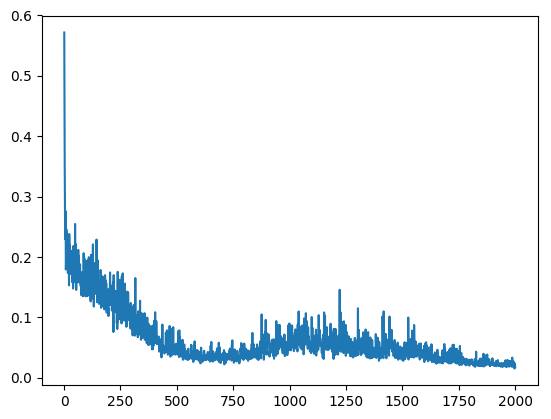

In [ ]:

# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_unet/unet.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

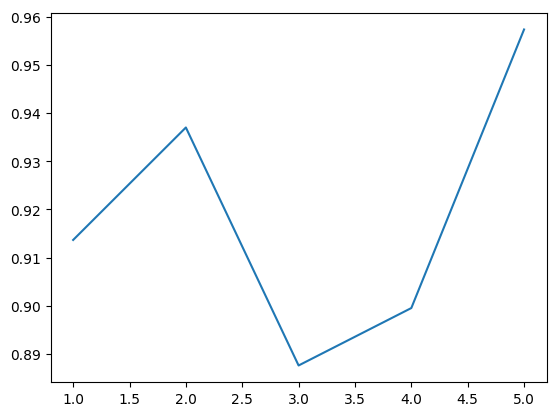

In [ ]:
# 读取图像绘图 
# 可以加一些修饰
dice=np.load('output_unet/dice_values.npy')
x=range(1,len(dice)+1)
plt.plot(x,dice)

# **AttentionUnet**

要求中应该没有这个

In [14]:
from paddleseg.models import AttentionUNet

# 创建attention_unet模型
attentionunet_model = AttentionUNet(num_classes=2)

# 其余的训练设置保持不变...

# 为attention_unet创建优化器
attention_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=attentionunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=attentionunet_model,
    filename='attentionunet.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=attention_optimizer,
    save_dir='output_attentionunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_attentionunet/attentionunet.npy
output_attentionunet/dice_values.npy


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


KeyboardInterrupt: 

# **Unet++**

In [ ]:
from paddleseg.models import UNet,UNetPlusPlus,UNet3Plus

unetpp_model = UNetPlusPlus(num_classes=2)

# unet++
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=unetpp_model.parameters(),
    weight_decay=4.0e-5
)

train(
    model=unetpp_model,
    filename='unetpp.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output_unet++',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

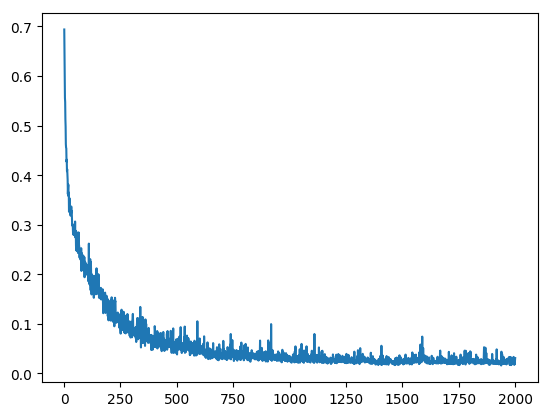

In [15]:
# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_unet++/unetpp.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

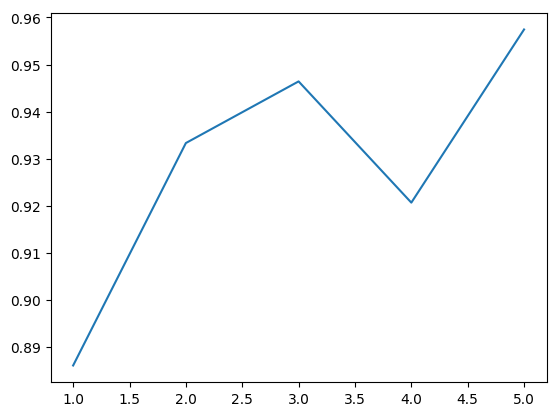

In [16]:
# 读取图像绘图 
# 可以加一些修饰
dice=np.load('output_unet++/dice_values.npy')
x=range(1,len(dice)+1)
plt.plot(x,dice)

# **Unet3+**

这个应该也没有要求

In [ ]:
unet3p_model = UNet3Plus(num_classes=2)

# unet3+
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=unet3p_model.parameters(),
    weight_decay=4.0e-5
)

train(
    model=unet3p_model,
    filename='unet3p.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output_unet3+',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

In [17]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

from paddleseg.cvlibs import manager
from paddleseg.models import layers
from paddleseg.utils import utils

__all__ = ['U2Net', 'U2Netp']


@manager.MODELS.add_component
class U2Net(nn.Layer):
    """
    The U^2-Net implementation based on PaddlePaddle.

    The original article refers to
    Xuebin Qin, et, al. "U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
    (https://arxiv.org/abs/2005.09007).

    Args:
        num_classes (int): The unique number of target classes.
        in_channels (int, optional): Input channels. Default: 3.
        pretrained (str, optional): The path or url of pretrained model for fine tuning. Default: None.

    """

    def __init__(self, num_classes=2, in_channels=3, pretrained=None):
        super(U2Net, self).__init__()

        self.stage1 = RSU7(in_channels, 32, 64)
        self.pool12 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(512, 256, 512)

        # decoder
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4(1024, 128, 256)
        self.stage3d = RSU5(512, 64, 128)
        self.stage2d = RSU6(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2D(64, num_classes, 3, padding=1)
        self.side2 = nn.Conv2D(64, num_classes, 3, padding=1)
        self.side3 = nn.Conv2D(128, num_classes, 3, padding=1)
        self.side4 = nn.Conv2D(256, num_classes, 3, padding=1)
        self.side5 = nn.Conv2D(512, num_classes, 3, padding=1)
        self.side6 = nn.Conv2D(512, num_classes, 3, padding=1)

        self.outconv = nn.Conv2D(6 * num_classes, num_classes, 1)

        self.pretrained = pretrained
        self.init_weight()

    def forward(self, x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(paddle.concat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(paddle.concat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(paddle.concat((hx2dup, hx1), 1))

        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(paddle.concat((d1, d2, d3, d4, d5, d6), 1))
        # if d0.shape[1] > 1:
        #     d0 = d0[:, 0, :, :].unsqueeze(1)
        return [d0]

    def init_weight(self):
        if self.pretrained is not None:
            utils.load_entire_model(self, self.pretrained)

class REBNCONV(nn.Layer):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2D(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate)
        self.bn_s1 = nn.BatchNorm2D(out_ch)
        self.relu_s1 = nn.ReLU()

    def forward(self, x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):

    src = F.upsample(src, size=paddle.shape(tar)[2:], mode='bilinear')

    return src
### RSU-7 ###
class RSU7(nn.Layer):  #UNet07DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(paddle.concat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(paddle.concat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(paddle.concat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Layer):  #UNet06DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(paddle.concat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(paddle.concat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Layer):  #UNet05DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(paddle.concat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Layer):  #UNet04DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Layer):  #UNet04FRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(paddle.concat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(paddle.concat((hx2d, hx1), 1))

        return hx1d + hxin


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddleseg/cvlibs/manager.py:114: UserWarning: U2Net exists already! It is now updated to <class '__main__.U2Net'> !!!
  format(component_name, component))


# **u2net**

In [18]:
# from paddle.nn import BCELoss  # 假设您使用的是二元交叉熵损失
# from paddleseg.models import U2Net
# losses = {
#     'types': [BCELoss(),BCELoss(),BCELoss(),BCELoss(),BCELoss(),BCELoss(),BCELoss()],
#     'coef': [1,1,1,1,1,1,1]  # 假设您对所有输出的损失都赋予相同的权重
# }

losses = {}
losses['types'] = [BCELoss()] 
losses['coef'] = [1]

u2net_model = U2Net(num_classes=2)
batch_size = 1
# u2net
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=u2net_model.parameters(),
    weight_decay=4.0e-5
)

train(
    model=u2net_model,
    filename='u2net.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output_u2net',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_u2net/u2net.npy
output_u2net/dice_values.npy
2023-12-30 10:14:08 [INFO]	[TRAIN] epoch: 1, iter: 10/2000, loss: 0.3968, lr: 0.001000, batch_cost: 0.1508, reader_cost: 0.00140, ips: 6.6308 samples/sec | ETA 00:05:00
2023-12-30 10:14:09 [INFO]	[TRAIN] epoch: 1, iter: 20/2000, loss: 0.4886, lr: 0.001000, batch_cost: 0.1274, reader_cost: 0.00013, ips: 7.8507 samples/sec | ETA 00:04:12
2023-12-30 10:14:10 [INFO]	[TRAIN] epoch: 1, iter: 30/2000, loss: 0.3455, lr: 0.001000, batch_cost: 0.1325, reader_cost: 0.00047, ips: 7.5449 samples/sec | ETA 00:04:21
2023-12-30 10:14:11 [INFO]	[TRAIN] epoch: 1, iter: 40/2000, loss: 0.2538, lr: 0.001000, batch_cost: 0.1286, reader_cost: 0.00015, ips: 7.7775 samples/sec | ETA 00:04:12
2023-12-30 10:14:13 [INFO]	[TRAIN] epoch: 1, iter: 50/2000, loss: 0.3453, lr: 0.001000, batch_cost: 0.1303, reader_cost: 0.00016, ips: 7.6755 samples/sec | ETA 00:04:14
2023-12-30 10:14:14 [INFO]	[TRAIN] epoch: 1, iter: 60/2000, loss: 0.1229, lr: 0.001000, batch_cost: 0.1

27/27 [==============================] - 2s 58ms/step - batch_cost: 0.0566 - reader cost: 4.6477e-0


2023-12-30 10:15:00 [INFO]	[EVAL] #Images: 27 mIoU: 0.2951 Acc: 0.5210 Kappa: 0.0815 Dice: 0.4178
2023-12-30 10:15:00 [INFO]	[EVAL] Class IoU: 
[0.4957 0.0946]
2023-12-30 10:15:00 [INFO]	[EVAL] Class Precision: 
[0.9898 0.0954]
2023-12-30 10:15:00 [INFO]	[EVAL] Class Recall: 
[0.4983 0.9117]
2023-12-30 10:15:06 [INFO]	[EVAL] The model with the best validation mIoU (0.2951) was saved at iter 400.
2023-12-30 10:15:07 [INFO]	[TRAIN] epoch: 2, iter: 410/2000, loss: 0.2000, lr: 0.001000, batch_cost: 0.1337, reader_cost: 0.00017, ips: 7.4787 samples/sec | ETA 00:03:32
2023-12-30 10:15:09 [INFO]	[TRAIN] epoch: 2, iter: 420/2000, loss: 0.1538, lr: 0.001000, batch_cost: 0.1342, reader_cost: 0.00017, ips: 7.4502 samples/sec | ETA 00:03:32
2023-12-30 10:15:10 [INFO]	[TRAIN] epoch: 2, iter: 430/2000, loss: 0.1533, lr: 0.001000, batch_cost: 0.1306, reader_cost: 0.00015, ips: 7.6595 samples/sec | ETA 00:03:24
2023-12-30 10:15:11 [INFO]	[TRAIN] epoch: 3, iter: 440/2000, loss: 0.1804, lr: 0.001000, ba

27/27 [==============================] - 1s 55ms/step - batch_cost: 0.0539 - reader cost: 6.4570e-0


2023-12-30 10:15:59 [INFO]	[EVAL] #Images: 27 mIoU: 0.6554 Acc: 0.9535 Kappa: 0.5037 Dice: 0.7517
2023-12-30 10:15:59 [INFO]	[EVAL] Class IoU: 
[0.9523 0.3585]
2023-12-30 10:15:59 [INFO]	[EVAL] Class Precision: 
[0.9698 0.5964]
2023-12-30 10:15:59 [INFO]	[EVAL] Class Recall: 
[0.9814 0.4734]
2023-12-30 10:16:05 [INFO]	[EVAL] The model with the best validation mIoU (0.6554) was saved at iter 800.
2023-12-30 10:16:07 [INFO]	[TRAIN] epoch: 4, iter: 810/2000, loss: 0.1409, lr: 0.001000, batch_cost: 0.1333, reader_cost: 0.00018, ips: 7.5012 samples/sec | ETA 00:02:38
2023-12-30 10:16:08 [INFO]	[TRAIN] epoch: 4, iter: 820/2000, loss: 0.1214, lr: 0.001000, batch_cost: 0.1327, reader_cost: 0.00017, ips: 7.5354 samples/sec | ETA 00:02:36
2023-12-30 10:16:09 [INFO]	[TRAIN] epoch: 4, iter: 830/2000, loss: 0.1407, lr: 0.001000, batch_cost: 0.1323, reader_cost: 0.00016, ips: 7.5583 samples/sec | ETA 00:02:34
2023-12-30 10:16:11 [INFO]	[TRAIN] epoch: 4, iter: 840/2000, loss: 0.1638, lr: 0.001000, ba

27/27 [==============================] - 2s 57ms/step - batch_cost: 0.0557 - reader cost: 4.9160e-0


2023-12-30 10:17:00 [INFO]	[EVAL] #Images: 27 mIoU: 0.7023 Acc: 0.9566 Kappa: 0.5974 Dice: 0.7987
2023-12-30 10:17:00 [INFO]	[EVAL] Class IoU: 
[0.9551 0.4496]
2023-12-30 10:17:00 [INFO]	[EVAL] Class Precision: 
[0.9793 0.5971]
2023-12-30 10:17:00 [INFO]	[EVAL] Class Recall: 
[0.9747 0.6454]
2023-12-30 10:17:05 [INFO]	[EVAL] The model with the best validation mIoU (0.7023) was saved at iter 1200.
2023-12-30 10:17:07 [INFO]	[TRAIN] epoch: 6, iter: 1210/2000, loss: 0.1240, lr: 0.001000, batch_cost: 0.1479, reader_cost: 0.00023, ips: 6.7607 samples/sec | ETA 00:01:56
2023-12-30 10:17:08 [INFO]	[TRAIN] epoch: 6, iter: 1220/2000, loss: 0.1317, lr: 0.001000, batch_cost: 0.1355, reader_cost: 0.00020, ips: 7.3799 samples/sec | ETA 00:01:45
2023-12-30 10:17:09 [INFO]	[TRAIN] epoch: 6, iter: 1230/2000, loss: 0.0775, lr: 0.001000, batch_cost: 0.1259, reader_cost: 0.00018, ips: 7.9424 samples/sec | ETA 00:01:36
2023-12-30 10:17:11 [INFO]	[TRAIN] epoch: 6, iter: 1240/2000, loss: 0.1630, lr: 0.00100

27/27 [==============================] - 2s 57ms/step - batch_cost: 0.0558 - reader cost: 6.5341e-0


2023-12-30 10:18:00 [INFO]	[EVAL] #Images: 27 mIoU: 0.7321 Acc: 0.9586 Kappa: 0.6515 Dice: 0.8255
2023-12-30 10:18:00 [INFO]	[EVAL] Class IoU: 
[0.9568 0.5074]
2023-12-30 10:18:00 [INFO]	[EVAL] Class Precision: 
[0.9868 0.5941]
2023-12-30 10:18:00 [INFO]	[EVAL] Class Recall: 
[0.9692 0.7766]
2023-12-30 10:18:03 [INFO]	[EVAL] The model with the best validation mIoU (0.7321) was saved at iter 1600.
2023-12-30 10:18:04 [INFO]	[TRAIN] epoch: 8, iter: 1610/2000, loss: 0.1653, lr: 0.001000, batch_cost: 0.1316, reader_cost: 0.00020, ips: 7.5964 samples/sec | ETA 00:00:51
2023-12-30 10:18:06 [INFO]	[TRAIN] epoch: 8, iter: 1620/2000, loss: 0.0872, lr: 0.001000, batch_cost: 0.1331, reader_cost: 0.00018, ips: 7.5143 samples/sec | ETA 00:00:50
2023-12-30 10:18:07 [INFO]	[TRAIN] epoch: 8, iter: 1630/2000, loss: 0.1788, lr: 0.001000, batch_cost: 0.1362, reader_cost: 0.00017, ips: 7.3411 samples/sec | ETA 00:00:50
2023-12-30 10:18:08 [INFO]	[TRAIN] epoch: 8, iter: 1640/2000, loss: 0.1178, lr: 0.00100

27/27 [==============================] - 1s 55ms/step - batch_cost: 0.0541 - reader cost: 6.5547e-0


2023-12-30 10:18:57 [INFO]	[EVAL] #Images: 27 mIoU: 0.7033 Acc: 0.9609 Kappa: 0.5974 Dice: 0.7986
2023-12-30 10:18:57 [INFO]	[EVAL] Class IoU: 
[0.9597 0.447 ]
2023-12-30 10:18:57 [INFO]	[EVAL] Class Precision: 
[0.9756 0.6668]
2023-12-30 10:18:57 [INFO]	[EVAL] Class Recall: 
[0.9833 0.5756]
2023-12-30 10:18:59 [INFO]	[EVAL] The model with the best validation mIoU (0.7321) was saved at iter 1600.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


Total Flops: 37672822400     Total Params: 44052518


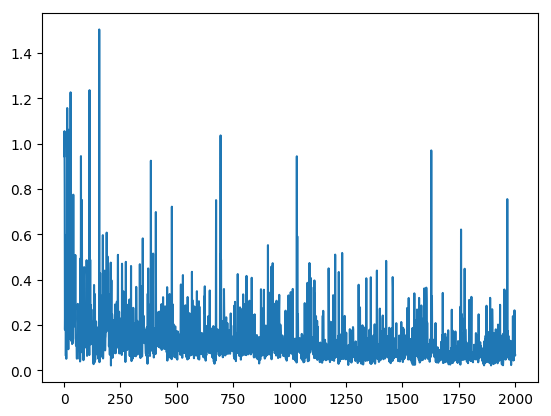

In [19]:
# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_u2net/u2net.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

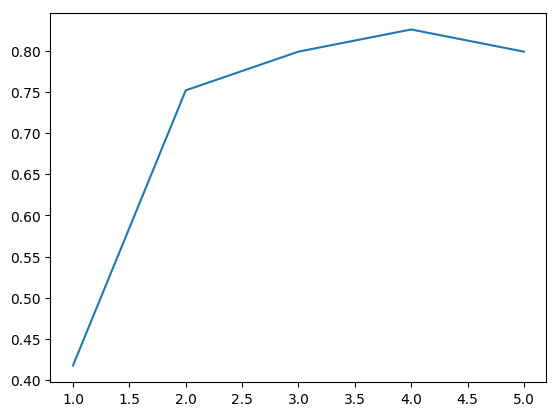

In [20]:
# 读取图像绘图 
# 可以加一些修饰
dice=np.load('output_u2net/dice_values.npy')
x=range(1,len(dice)+1)
plt.plot(x,dice)

# **注意力模型**

In [21]:
import paddle
import paddle.nn as nn
class ChannelAttention(nn.Layer):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2D(1)
        self.max_pool = nn.AdaptiveMaxPool2D(1)
        self.fc1 = nn.Conv2D(in_channels, in_channels // reduction_ratio, 1, bias_attr=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2D(in_channels // reduction_ratio, in_channels, 1, bias_attr=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
class SpatialAttention(nn.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2D(2, 1, kernel_size, padding=padding, bias_attr=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = paddle.mean(x, axis=1, keepdim=True)
        max_out= paddle.max(x, axis=1, keepdim=True)
        x = paddle.concat([avg_out, max_out], axis=1)
        x = self.conv(x)
        return self.sigmoid(x)
class CBAM(nn.Layer):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

In [22]:
class SEAttention(nn.Layer):
    def __init__(self, in_channels, hidden_channels=None):
        super(SEAttention, self).__init__()
        
        if hidden_channels is None:
            hidden_channels = in_channels // 8
        
        self.pool = nn.AdaptiveAvgPool2D(output_size=(1, 1))
        self.fc1 = nn.Conv2D(in_channels, hidden_channels, kernel_size=1, bias_attr=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2D(hidden_channels, in_channels, kernel_size=1, bias_attr=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        y = self.pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

In [23]:
class SPA(nn.Layer):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool1 = nn.AdaptiveAvgPool2D(1)
        self.avg_pool2 = nn.AdaptiveAvgPool2D(2)
        self.avg_pool4 = nn.AdaptiveAvgPool2D(4)
        self.fc = nn.Sequential(
            nn.Linear(channel * 21, channel // reduction, bias_attr=False),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel, bias_attr=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y1 = self.avg_pool1(x).reshape((b, -1))
        y2 = self.avg_pool2(x).reshape((b, -1))
        y3 = self.avg_pool4(x).reshape((b, -1))
        y = paddle.concat((y1, y2, y3), 1)
        y = self.fc(y).reshape((b, c, 1, 1))
        return x * y

In [24]:
# 加入注意力机制之后，重写unet，形成senet-unet和cbam-unet
# 可以参考SE与CBAM注意力机制改进的U-Net_副本，之前上课的一个练习

# 编码器
# 其中nn.Layer表示该类继承自PaddlePaddle的深度学习网络层（layer），
# 表明Encoder本质上是一个神经网络模型。
class Encoder(nn.Layer):
    def __init__(self, num_channels, num_filters,attention=False):
        # super(Encoder, self)调用Encoder类的父类，并且将当前实例对象
        # self作为参数传递给它，以便在父类中进行相应的初始化工作。然后通过__init__()
        # 方法完成Encoder这个子类自己的初始化工作。
        super(Encoder,self).__init__()
        if attention is False:
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),             
                nn.BatchNorm(num_filters, act="relu")
            )
        elif attention=='CBAM':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                CBAM(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )
        elif attention=='SEAttention':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                SEAttention(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )
        elif attention == 'SPA':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                SPA(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )

        # 池化层，图片尺寸减半[H/2 W/2]
        self.pool = nn.MaxPool2D(kernel_size=2, stride=2, padding="SAME")
    def forward(self,inputs):
        x = self.features(inputs)
        x_conv = x
        x_pool = self.pool(x)
        # 返回池化之前的与  池化之后的
        return x_conv, x_pool 

# paddle.summary(Encoder(3,64,'SEAttention'), (1, 3, 128, 128))

In [25]:
class Decoder(nn.Layer):
    def __init__(self, num_channels,num_filters,attention=False):
        super(Decoder,self).__init__()
        if attention is False:
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),             
                nn.BatchNorm(num_filters, act="relu")
            )

        elif attention=='CBAM':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                CBAM(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )
        elif attention=='SEAttention':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                SEAttention(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                ) 
        # 图片尺寸变大一倍[2*H 2*W]
        self.up = nn.Conv2DTranspose(num_channels,num_filters,2,2,padding=0)

    def forward(self,input_conv,input_pool):
        
        x = self.up(input_pool)
        h_diff = (input_conv.shape[2] - x.shape[2])
        w_diff = (input_conv.shape[3] - x.shape[3])
        # #以下采样保存的feature map为基准，填充上采样的feature map尺寸
        # padding=[上，下，左，右]填充空白像素
        pad = nn.Pad2D(padding=[h_diff//2, h_diff - h_diff//2, w_diff//2, w_diff-w_diff//2])
        x = pad(x)
        # in_channels扩大两倍
        x = paddle.concat([input_conv, x], axis=1)
        x = self.features(x)
        return x

In [26]:
class UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64,attention=False) #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention=False)
        self.down3 = Encoder(num_channels=128, num_filters=256,attention=False)
        self.down4 = Encoder(num_channels=256, num_filters=512,attention=False)
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        
        return x


# paddle.summary(UNet(2), (1, 3, 128, 128))

In [27]:
class SEAttention_UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(SEAttention_UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64, attention='SEAttention') #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention='SEAttention')
        self.down3 = Encoder(num_channels=128, num_filters=256,attention='SEAttention')
        self.down4 = Encoder(num_channels=256, num_filters=512,attention='SEAttention')

        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)

        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        x = self.last_conv(x)
        logit_list = [x]
        # print("Output shape:", x.shape)
        return logit_list


# paddle.summary(SEAttention_UNet(), (1, 3, 128, 128))

In [28]:
class CBAM_UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(CBAM_UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64, attention='CBAM') #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention='CBAM')
        self.down3 = Encoder(num_channels=128, num_filters=256,attention='CBAM')
        self.down4 = Encoder(num_channels=256, num_filters=512,attention='CBAM')
        
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        logit_list = [x]
        
        return logit_list


# paddle.summary(CBAM_UNet(), (1, 3, 128, 128))

In [29]:
class SPA_UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(SPA_UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64, attention='SPA') #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention='SPA')
        self.down3 = Encoder(num_channels=128, num_filters=256,attention='SPA')
        self.down4 = Encoder(num_channels=256, num_filters=512,attention='SPA')
        
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        logit_list = [x]
        
        return logit_list


# paddle.summary(CBAM_UNet(), (1, 3, 128, 128))

# **SEAttention**

In [30]:
# 带有注意力机制的模型已经建立完成
# 现在开始训练
# paddle.device.set_device('gpu:0')

losses = {}
losses['types'] = [BCELoss()] 
losses['coef'] = [1]

batch_size = 16
seunet_model = SEAttention_UNet()

# 为seunet_model创建优化器
seunet_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=seunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=seunet_model,
    filename='seunet_model.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=seunet_optimizer,
    save_dir='output_seunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_seunet/seunet_model.npy
output_seunet/dice_values.npy
2023-12-30 10:19:52 [INFO]	[TRAIN] epoch: 1, iter: 10/2000, loss: 0.4699, lr: 0.001000, batch_cost: 0.3817, reader_cost: 0.10191, ips: 41.9208 samples/sec | ETA 00:12:39
2023-12-30 10:19:56 [INFO]	[TRAIN] epoch: 2, iter: 20/2000, loss: 0.2916, lr: 0.001000, batch_cost: 0.3820, reader_cost: 0.10296, ips: 41.8819 samples/sec | ETA 00:12:36
2023-12-30 10:20:00 [INFO]	[TRAIN] epoch: 3, iter: 30/2000, loss: 0.2453, lr: 0.001000, batch_cost: 0.3892, reader_cost: 0.10974, ips: 41.1143 samples/sec | ETA 00:12:46
2023-12-30 10:20:04 [INFO]	[TRAIN] epoch: 4, iter: 40/2000, loss: 0.2202, lr: 0.001000, batch_cost: 0.3899, reader_cost: 0.11066, ips: 41.0353 samples/sec | ETA 00:12:44
2023-12-30 10:20:07 [INFO]	[TRAIN] epoch: 4, iter: 50/2000, loss: 0.2132, lr: 0.001000, batch_cost: 0.3763, reader_cost: 0.09736, ips: 42.5178 samples/sec | ETA 00:12:13
2023-12-30 10:20:11 [INFO]	[TRAIN] epoch: 5, iter: 60/2000, loss: 0.2072, lr: 0.001000, b

27/27 [==============================] - 0s 17ms/step - batch_cost: 0.0165 - reader cost: 4.0242e-0


2023-12-30 10:22:22 [INFO]	[EVAL] #Images: 27 mIoU: 0.5755 Acc: 0.8828 Kappa: 0.3799 Dice: 0.6822
2023-12-30 10:22:22 [INFO]	[EVAL] Class IoU: 
[0.8773 0.2737]
2023-12-30 10:22:22 [INFO]	[EVAL] Class Precision: 
[0.9874 0.2931]
2023-12-30 10:22:22 [INFO]	[EVAL] Class Recall: 
[0.8873 0.805 ]
2023-12-30 10:22:23 [INFO]	[EVAL] The model with the best validation mIoU (0.5755) was saved at iter 400.
2023-12-30 10:22:27 [INFO]	[TRAIN] epoch: 32, iter: 410/2000, loss: 0.1161, lr: 0.001000, batch_cost: 0.3609, reader_cost: 0.07742, ips: 44.3293 samples/sec | ETA 00:09:33
2023-12-30 10:22:30 [INFO]	[TRAIN] epoch: 33, iter: 420/2000, loss: 0.1126, lr: 0.001000, batch_cost: 0.3894, reader_cost: 0.10682, ips: 41.0868 samples/sec | ETA 00:10:15
2023-12-30 10:22:34 [INFO]	[TRAIN] epoch: 34, iter: 430/2000, loss: 0.1057, lr: 0.001000, batch_cost: 0.3907, reader_cost: 0.10763, ips: 40.9481 samples/sec | ETA 00:10:13
2023-12-30 10:22:38 [INFO]	[TRAIN] epoch: 34, iter: 440/2000, loss: 0.1038, lr: 0.001

27/27 [==============================] - 1s 21ms/step - batch_cost: 0.0201 - reader cost: 4.5228e-


2023-12-30 10:24:59 [INFO]	[EVAL] #Images: 27 mIoU: 0.7258 Acc: 0.9510 Kappa: 0.6450 Dice: 0.8215
2023-12-30 10:24:59 [INFO]	[EVAL] Class IoU: 
[0.9485 0.5032]
2023-12-30 10:24:59 [INFO]	[EVAL] Class Precision: 
[0.9942 0.5316]
2023-12-30 10:24:59 [INFO]	[EVAL] Class Recall: 
[0.9537 0.9041]
2023-12-30 10:25:00 [INFO]	[EVAL] The model with the best validation mIoU (0.7258) was saved at iter 800.
2023-12-30 10:25:04 [INFO]	[TRAIN] epoch: 63, iter: 810/2000, loss: 0.0579, lr: 0.001000, batch_cost: 0.3417, reader_cost: 0.05811, ips: 46.8252 samples/sec | ETA 00:06:46
2023-12-30 10:25:08 [INFO]	[TRAIN] epoch: 64, iter: 820/2000, loss: 0.0523, lr: 0.001000, batch_cost: 0.3939, reader_cost: 0.11084, ips: 40.6197 samples/sec | ETA 00:07:44
2023-12-30 10:25:11 [INFO]	[TRAIN] epoch: 64, iter: 830/2000, loss: 0.0470, lr: 0.001000, batch_cost: 0.3897, reader_cost: 0.10594, ips: 41.0545 samples/sec | ETA 00:07:35
2023-12-30 10:25:15 [INFO]	[TRAIN] epoch: 65, iter: 840/2000, loss: 0.0486, lr: 0.001

27/27 [==============================] - 1s 21ms/step - batch_cost: 0.0201 - reader cost: 4.9476e-


2023-12-30 10:27:38 [INFO]	[EVAL] #Images: 27 mIoU: 0.9002 Acc: 0.9889 Kappa: 0.8905 Dice: 0.9452
2023-12-30 10:27:38 [INFO]	[EVAL] Class IoU: 
[0.9884 0.8121]
2023-12-30 10:27:38 [INFO]	[EVAL] Class Precision: 
[0.9925 0.9237]
2023-12-30 10:27:38 [INFO]	[EVAL] Class Recall: 
[0.9958 0.8705]
2023-12-30 10:27:38 [INFO]	[EVAL] The model with the best validation mIoU (0.9002) was saved at iter 1200.
2023-12-30 10:27:42 [INFO]	[TRAIN] epoch: 94, iter: 1210/2000, loss: 0.0428, lr: 0.001000, batch_cost: 0.3412, reader_cost: 0.05738, ips: 46.8915 samples/sec | ETA 00:04:29
2023-12-30 10:27:46 [INFO]	[TRAIN] epoch: 94, iter: 1220/2000, loss: 0.0345, lr: 0.001000, batch_cost: 0.3921, reader_cost: 0.10896, ips: 40.8030 samples/sec | ETA 00:05:05
2023-12-30 10:27:50 [INFO]	[TRAIN] epoch: 95, iter: 1230/2000, loss: 0.0383, lr: 0.001000, batch_cost: 0.3997, reader_cost: 0.11664, ips: 40.0277 samples/sec | ETA 00:05:07
2023-12-30 10:27:54 [INFO]	[TRAIN] epoch: 96, iter: 1240/2000, loss: 0.0417, lr: 

27/27 [==============================] - 1s 20ms/step - batch_cost: 0.0191 - reader cost: 5.0976e-


2023-12-30 10:30:16 [INFO]	[EVAL] #Images: 27 mIoU: 0.9004 Acc: 0.9891 Kappa: 0.8906 Dice: 0.9453
2023-12-30 10:30:16 [INFO]	[EVAL] Class IoU: 
[0.9885 0.8122]
2023-12-30 10:30:16 [INFO]	[EVAL] Class Precision: 
[0.9919 0.9354]
2023-12-30 10:30:16 [INFO]	[EVAL] Class Recall: 
[0.9966 0.8605]
2023-12-30 10:30:17 [INFO]	[EVAL] The model with the best validation mIoU (0.9004) was saved at iter 1600.
2023-12-30 10:30:20 [INFO]	[TRAIN] epoch: 124, iter: 1610/2000, loss: 0.0340, lr: 0.001000, batch_cost: 0.3362, reader_cost: 0.05310, ips: 47.5935 samples/sec | ETA 00:02:11
2023-12-30 10:30:24 [INFO]	[TRAIN] epoch: 125, iter: 1620/2000, loss: 0.0327, lr: 0.001000, batch_cost: 0.3913, reader_cost: 0.10871, ips: 40.8945 samples/sec | ETA 00:02:28
2023-12-30 10:30:28 [INFO]	[TRAIN] epoch: 126, iter: 1630/2000, loss: 0.0301, lr: 0.001000, batch_cost: 0.3943, reader_cost: 0.11170, ips: 40.5784 samples/sec | ETA 00:02:25
2023-12-30 10:30:32 [INFO]	[TRAIN] epoch: 127, iter: 1640/2000, loss: 0.0322, 

27/27 [==============================] - 0s 17ms/step - batch_cost: 0.0166 - reader cost: 4.2270e-0


2023-12-30 10:32:54 [INFO]	[EVAL] #Images: 27 mIoU: 0.9154 Acc: 0.9907 Kappa: 0.9085 Dice: 0.9542
2023-12-30 10:32:54 [INFO]	[EVAL] Class IoU: 
[0.9903 0.8406]
2023-12-30 10:32:54 [INFO]	[EVAL] Class Precision: 
[0.9937 0.9375]
2023-12-30 10:32:54 [INFO]	[EVAL] Class Recall: 
[0.9966 0.8905]
2023-12-30 10:32:55 [INFO]	[EVAL] The model with the best validation mIoU (0.9154) was saved at iter 2000.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.fluid.dygraph.nn.BatchNorm'>'s flops has been counted
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.activation.Sigmoid'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.conv.Conv2DTranspose'>'s flops has been counted
Total Flops: 51504700408     Tota

/home/aistudio/PaddleSeg


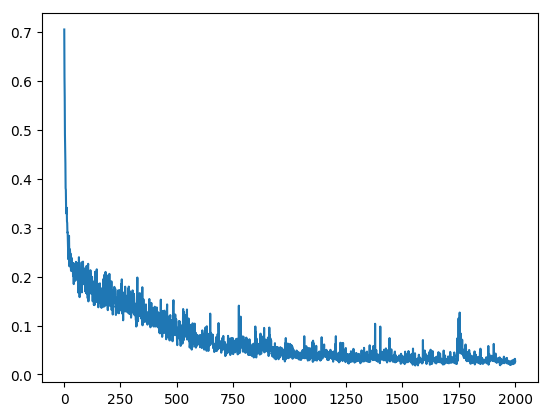

In [31]:
%cd ~/PaddleSeg/
# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_seunet/seunet_model.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

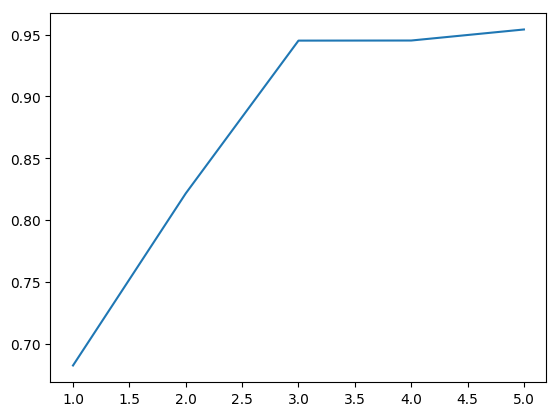

In [32]:
# 读取图像绘图 
# 可以加一些修饰
dice=np.load('output_seunet/dice_values.npy')
x=range(1,len(dice)+1)
plt.plot(x,dice)

# CBAM

In [ ]:
# 带有注意力机制的模型已经建立完成
# 现在开始训练
paddle.device.set_device('gpu:0')

losses = {}
losses['types'] = [BCELoss()] 
losses['coef'] = [1]
batch_size = 16
cbamunet_model = CBAM_UNet()

# 为cbamunet_model创建优化器
cbamunet_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=cbamunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=cbamunet_model,
    filename='CBAMunet_model.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=cbamunet_optimizer,
    save_dir='output_CBAMunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_CBAMunet/CBAMunet_model.npy
output_CBAMunet/dice_values.npy
2023-12-30 10:34:03 [INFO]	[TRAIN] epoch: 1, iter: 10/2000, loss: 0.4421, lr: 0.001000, batch_cost: 0.4748, reader_cost: 0.09055, ips: 33.6961 samples/sec | ETA 00:15:44
2023-12-30 10:34:08 [INFO]	[TRAIN] epoch: 2, iter: 20/2000, loss: 0.2757, lr: 0.001000, batch_cost: 0.4799, reader_cost: 0.09856, ips: 33.3427 samples/sec | ETA 00:15:50
2023-12-30 10:34:13 [INFO]	[TRAIN] epoch: 3, iter: 30/2000, loss: 0.2322, lr: 0.001000, batch_cost: 0.4845, reader_cost: 0.10207, ips: 33.0265 samples/sec | ETA 00:15:54
2023-12-30 10:34:17 [INFO]	[TRAIN] epoch: 4, iter: 40/2000, loss: 0.2074, lr: 0.001000, batch_cost: 0.4762, reader_cost: 0.09483, ips: 33.6018 samples/sec | ETA 00:15:33
2023-12-30 10:34:22 [INFO]	[TRAIN] epoch: 4, iter: 50/2000, loss: 0.2154, lr: 0.001000, batch_cost: 0.4794, reader_cost: 0.09753, ips: 33.3724 samples/sec | ETA 00:15:34
2023-12-30 10:34:27 [INFO]	[TRAIN] epoch: 5, iter: 60/2000, loss: 0.2000, lr: 0.001

In [ ]:
# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_CBAMunet/CBAMunet_model.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

In [ ]:
# 读取图像绘图 
# 可以加一些修饰
dice=np.load('output_CBAMunet/dice_values.npy')
x=range(1,len(dice)+1)
plt.plot(x,dice)

# SPA_unet

In [ ]:
# 带有注意力机制的模型已经建立完成
# 现在开始训练
paddle.device.set_device('gpu:0')

losses = {}
losses['types'] = [BCELoss()] 
losses['coef'] = [1]
batch_size = 16
spaunet_model = SPA_UNet()

# 为spanet_model创建优化器
spanet_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=spaunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=spaunet_model,
    filename='SPA_unet_model.npy',
    dicepath = 'dice_values.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=spanet_optimizer,
    save_dir='output_SPAunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

In [ ]:
%cd ~/PaddleSeg/
# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_SPAunet/SPA_unet_model.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

In [ ]:
# 读取图像绘图 
# 可以加一些修饰
dice=np.load('output_SPAunet/dice_values.npy')
x=range(1,len(dice)+1)
plt.plot(x,dice)

In [ ]:
import os
def get_image_list(image_path):
    """Get image list"""
    valid_suffix = [
        '.JPEG', '.jpeg', '.JPG', '.jpg', '.BMP', '.bmp', '.PNG', '.png'
    ]
    image_list = []
    image_dir = None
    if os.path.isfile(image_path):
        if os.path.splitext(image_path)[-1] in valid_suffix:
            image_list.append(image_path)
    elif os.path.isdir(image_path):
        image_dir = image_path
        for root, dirs, files in os.walk(image_path):
            for f in files:
                if os.path.splitext(f)[-1] in valid_suffix:
                    image_list.append(os.path.join(root, f))
    else:
        raise FileNotFoundError(
            '`--image_path` is not found. it should be an image file or a directory including images'
        )

    if len(image_list) == 0:
        raise RuntimeError('There are not image file in `--image_path`')

    return image_list, image_dir
!pwd
image_path = 'dataset/test1_img/' # 也可以输入一个包含图像的目录
image_list, image_dir = get_image_list('dataset/test1_img/')

# **#预测与评价指标**

In [ ]:
from paddleseg.models import UNet,UNetPlusPlus,UNet3Plus

unetpp_model = UNetPlusPlus(num_classes=2)
unet3p_model = UNet3Plus(num_classes=2)
u2net_model = U2Net(num_classes=2)
seunet_model = SEAttention_UNet()
cbamunet_model = CBAM_UNet()

# **unet**

In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=unet_model,
        model_path='output_unet/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_unet/results1'
    )

In [ ]:
def evaulate_miou(img_path,label_path):
    # print(imgs)
    iou=[]
    for img in os.listdir(img_path):
        imgpath=img_path+img
        img_1=cv2.imread(imgpath)
        img_test=np.zeros(img_1.shape[0:2])
        for n,i in enumerate(img_1):
            for m,j in enumerate(i):
                if j[1]==128:
                    img_test[n][m]=1
        data_path=label_path+img
        data=cv2.imread(data_path,-1)

        target=data
        prediction=img_test
        intersection = np.logical_and(target, prediction) 
        union = np.logical_or(target, prediction) 
        iou_score = np.sum(intersection) / np.sum(union)
        iou.append(iou_score)
    return iou

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_unet/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(iou_unet)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()

In [ ]:

# 绘制箱型图，观察离群值，说明大部分是正常预测的，除了极端部分，再解释下极端部分即可
fig, ax = plt.subplots()      # 子图
data=iou_unet
ax.boxplot(data)

# **Unet++**

In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=unetpp_model,
        model_path='output_unet++/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_unet++/results1'
    )

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_unet++/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()

In [ ]:
# 绘制箱型图，观察离群值，说明大部分是正常预测的，除了极端部分，再解释下极端部分即可
fig, ax = plt.subplots()      # 子图
data=iou_unet
ax.boxplot(data)

# **U2net**

In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=u2net_model,
        model_path='output_u2net/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_u2net/results1'
    )

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_u2net/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()

In [ ]:
# 绘制箱型图，观察离群值，说明大部分是正常预测的，除了极端部分，再解释下极端部分即可
fig, ax = plt.subplots()      # 子图
data=iou_unet
ax.boxplot(data)

# **seuent**

In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=seunet_model,
        model_path='output_seunet/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_seunet/results1'
    )

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_seunet/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()

In [ ]:
# 绘制箱型图，观察离群值，说明大部分是正常预测的，除了极端部分，再解释下极端部分即可
fig, ax = plt.subplots()      # 子图
data=iou_unet
ax.boxplot(data)

# **CBAMunet**

In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=cbamunet_model,
        model_path='output_CBAMunet/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_CBAMunet/results1'
    )

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_CBAMunet/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()

In [ ]:
# 绘制箱型图，观察离群值，说明大部分是正常预测的，除了极端部分，再解释下极端部分即可
fig, ax = plt.subplots()      # 子图
data=iou_unet
ax.boxplot(data)

# **SPA_unet**

In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=spaunet_model,
        model_path='output_SPAunet/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_SPAunet/results1'
    )

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_SPAunet/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()